In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import datetime
import pytz
import matplotlib.pyplot as plt
import preprocessing as prep
from bb_binary import FrameContainer, Repository, load_frame_container
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
start = "2016-07-21T15:00:00Z"
start_dt = datetime.datetime.strptime(start, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=pytz.UTC)
start_ts = start_dt.timestamp()
end_dt = start_dt + datetime.timedelta(minutes=5)
end_ts = end_dt.timestamp()

In [4]:
df3 = prep.getDF("/mnt/data2016/",start_ts, end_ts, 3)

In [5]:
df3.head(2)

,idx,xpos,ypos,radius,zRotation,decodedId,frame_idx,timestamp,cam_id,fc_id
0,0,75,1737,23.016102,-2.815818,"[16, 26, 12, 5, 6, 36, 2, 30, 5, 0, 54, 143]",0,1.469113e+09,3,13762910503243423769
1,1,148,2011,23.024433,-2.782721,"[254, 1, 6, 255, 2, 255, 0, 0, 0, 0, 255, 0]",0,1.469113e+09,3,13762910503243423769


In [7]:
len(df3.frame_idx.unique())

903

In [173]:
def df_to_timeseries_with_conf(df, conf, year):
    dfid = prep.calcIds(df,conf,year)
    gr = dfid.groupby(by='frame_idx')
    num_columns = dfid.frame_idx.unique().max() + 1
    u_id = dfid.id.unique()
    dft = DataFrame(0, index=u_id, columns=np.arange(num_columns))

    for i, group in gr:
        l = group['id']
        dft.loc[l,i] = 1
    
    return dft

In [10]:
def stat_dft(dft, conf):
    rows, columns = dft.shape
    mean = dft.apply(sum, axis=1).mean()
    minn = dft.apply(sum, axis=1).min()
    maxx =  dft.apply(sum, axis=1).max()
    sumsum =  dft.apply(sum, axis=1).sum()
    total = rows * columns
    return {'confidence': conf, 'rows': rows, 'columns': columns, 'mean': mean, 'min': minn, 'max': maxx, 'sum': sumsum, 'total': total}

In [37]:
def stats0(df):
    stats = []
    for i in np.arange(0,1.02,0.02):
        dft = df_to_timeseries_with_conf(df, i, 2016)
        dft = (dft-1)*(-1)
        stats.append(stat_dft(dft, i))
    
    st = DataFrame(stats)
    st.confidence *= 100
    st['sump'] = 100*st['sum']/st['total']
    
    return st

In [261]:
def stats95(df):
    stats = []
    for i in [0.95]:
        dft = df_to_timeseries_with_conf(df, i, 2016)
        dft = (dft-1)*(-1)
        stats.append(stat_dft(dft, i))
    
    st = DataFrame(stats)
    st.confidence *= 100
    st['sump'] = 100*st['sum']/st['total']
    
    return st

# Anzahle der Nullen pro Biene

In [ ]:
# für 95%

In [264]:
s95 = stats95(df3)

In [265]:
s95

,columns,confidence,max,mean,min,rows,sum,total,sump
0,903,95.0,902,812.719947,99,757,615229,683571,90.002209


In [38]:
s0 = stats0(df3)

In [39]:
s0['meanp'] = s0['mean']*100/s0['columns'] 

In [40]:
s0.tail(10)

,columns,confidence,max,mean,min,rows,sum,total,sump,meanp
41,903,82.0,902,835.915683,85,1186,991396,1070958,92.570950,92.570950
42,903,84.0,902,834.268122,86,1145,955237,1033935,92.388496,92.388496
43,903,86.0,902,831.139405,87,1076,894306,971628,92.042016,92.042016
44,903,88.0,902,827.698617,87,1012,837631,913836,91.660976,91.660976
45,903,90.0,902,823.890309,92,939,773633,847917,91.239237,91.239237
46,903,92.0,902,820.737557,94,884,725532,798252,90.890095,90.890095
47,903,94.0,902,815.854819,97,799,651868,721497,90.349371,90.349371
48,903,96.0,902,810.834483,102,725,587855,654675,89.793409,89.793409
49,903,98.0,902,798.791519,119,566,452116,511098,88.459747,88.459747
50,903,100.0,902,804.622276,237,413,332309,372939,89.105457,89.105457


In [41]:
sns.set_context("paper")

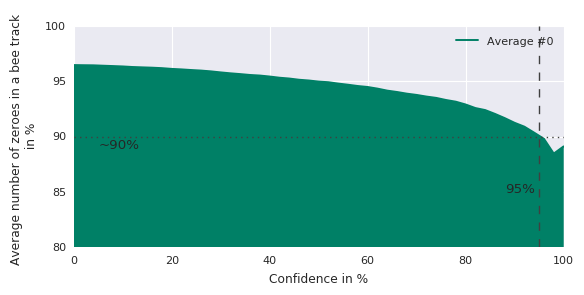

In [283]:
fig, ax = plt.subplots()
s0.plot.area(x='confidence', y='meanp', colormap='summer', ax=ax)
ax.legend(['Average #0'])
ax.set_ylabel("Average number of zeroes in a bee track \n in %")
ax.set_xlabel("Confidence in %")
ax.set_ylim((80,100))

# Confidence
plt.axvline(95, color='0.25', linestyle='dashed', linewidth=1)
plt.text(88,85,'95%',rotation=0)

# Data 59.139511
plt.axhline(90, color='0.25', linestyle='dotted', linewidth=1)
plt.text(5,89,'~90%',rotation=0)

fig.set_size_inches(5.91553,3)
plt.tight_layout()

# Anzahl der Einer Lücken pro Biene

In [275]:
def get_number_of_fragments(kette):

    kette = kette.apply(str)
    s = kette.str.cat(sep='')

    einer = [i for i in s.split('1') if len(i) > 0]
    nuller = [i for i in s.split('0') if len(i) > 0]
    
    return len(einer)+len(nuller)

In [276]:
def stat_ketten(s, conf):
    rows = s.shape[0]
    mean = s.mean()
    minn = s.min()
    maxx =  s.max()
    sumsum =  s.sum()
    return {'confidence': conf, 'rows': rows, 'mean': mean, 'min': minn, 'max': maxx, 'sum': sumsum}

In [277]:
def statsFragments(df):
    
    fragments = []
    
    for i in np.arange(0,1.05,0.05):
        
        dft = df_to_timeseries_with_conf(df, i, 2016)
        numFragments = dft.apply(get_number_of_fragments, axis=1)
        fragments.append(stat_ketten(numFragments, i))
    
    st = DataFrame(fragments)
    st.confidence *= 100
    
    return st

In [43]:
def statsK(df, gapsize):
    stats = []
    statsF = []
    for i in np.arange(0,1.02,0.02):
        dft = df_to_timeseries_with_conf(df, i, 2016)
        ketten = dft.apply(get_ketten_len, axis=1, args=["1"])
        anzahlEiner = ketten.apply(lambda x: len([elem for elem in x if elem == gapsize]))
        anzahlFragments = ketten.apply(lambda x: len(x))
        stats.append(stat_ketten(anzahlEiner, i))
        statsF.append(stat_ketten(anzahlFragments, i))
    
    st = DataFrame(stats)
    st.confidence *= 100
    
    stF = DataFrame(statsF)
    stF.confidence *= 100
    return st, stF

In [278]:
sF= statsFragments(df3)

In [281]:
len(df3.frame_idx.unique())

903

In [280]:
sF

,confidence,max,mean,min,rows,sum
0,0.0,303,20.125173,2,3619,72833
1,5.0,301,18.996223,2,3442,65385
2,10.0,307,18.445339,2,3229,59560
3,15.0,313,18.199804,2,3063,55746
4,20.0,315,18.081922,2,2893,52311
5,25.0,319,18.173834,2,2744,49869
6,30.0,324,18.539627,2,2574,47721
7,35.0,326,18.903534,2,2405,45463
8,40.0,328,19.317544,2,2280,44044
9,45.0,334,19.841639,2,2147,42600


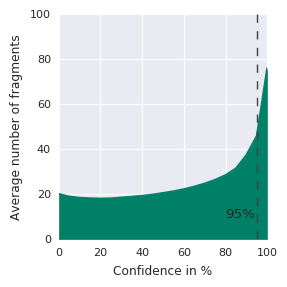

In [318]:
fig, ax = plt.subplots()
sF.plot.area(x='confidence', y='mean', colormap='summer', ax=ax, legend=False)

ax.set_ylabel("Average number of fragments")
ax.set_xlabel("Confidence in %")
ax.set_ylim((0,100))


# Confidence
plt.axvline(95, color='0.25', linestyle='dashed', linewidth=1)
plt.text(80,10,'95%',rotation=0)

fig.set_size_inches(5.91553/2,3)
plt.tight_layout()

plt.savefig('fragments.pdf')

In [60]:
sK1, sK1F = statsK(df3,1)

In [61]:
sK2, sK2F = statsK(df3,2)

In [62]:
sK3, sK3F = statsK(df3,3)

In [63]:
dfall = pd.concat([sK3.confidence, sK3['mean'], sK2['mean'], sK1['mean']], axis=1, keys=['confidence', 'gapsize3', 'gapsize2', 'gapsize1'])

In [300]:
dfall.head()

,confidence,gapsize3,gapsize2,gapsize1
0,0.0,0.505665,0.852169,2.166897
1,2.0,0.497303,0.862333,2.180528
2,4.0,0.493080,0.863033,2.201557
3,6.0,0.491551,0.869849,2.237474
4,8.0,0.498489,0.876058,2.267836


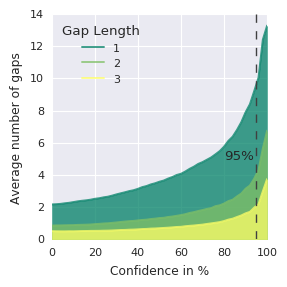

In [319]:
fig, ax = plt.subplots()
dfall.plot(x='confidence', y=['gapsize1', 'gapsize2', 'gapsize3'], colormap='summer', stacked=False, kind='area', alpha=0.75, ax=ax,)
ax.legend(['1', '2', '3'], loc="upper left", title="Gap Length")
ax.set_ylabel("Average number of gaps")
ax.set_xlabel("Confidence in %")


# Confidence
plt.axvline(95, color='0.25', linestyle='dashed', linewidth=1)
plt.text(80,5,'95%',rotation=0)

fig.set_size_inches(5.91553/2,3)
plt.tight_layout()

plt.savefig('gaps.pdf')